In [9]:
from multiprocessing import Pool
from sage.all import matrix  # testing
from sage.all import *
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from flatsurf import *
import os
import pwlf
from surface_dynamics.all import *
import math
from time import time
import copy
from scipy import integrate
import traceback
import dill
import sys
import unittest
from surface_dynamics.all import Origami
from utils import load_arrays_from_file  # testing
from fractions import Fraction as frac
import sympy as sym
from sympy import Symbol
from sympy import solve, lambdify, Eq
from sympy import Rational, sqrt
from Library import *
from Library import Section
from builtins import int
from collections import defaultdict

In [2]:
# number of squares for STS
n_squares = 6
# index to start at
index = 0
dx = 0.0005

In [22]:
permutations = perms_list(n_squares)
perm = permutations[index]
perm

(1)(2)(3)(4)(5,6)
(1,2,3,4,5)(6)

In [5]:
type(perm)

<class 'surface_dynamics.flat_surfaces.origamis.origami_dense.Origami_dense_pyx'>

In [27]:
# Define two permutations (for horizontal and vertical gluings)
h = '(1)'  # permutation for horizontal direction
v = '(1)'  # permutation for vertical direction

# Create the origami
origami = Origami(h, v)

# Verify the type
veech = origami.veech_group()

In [28]:
veech.index()

1

In [4]:
vec_file = "vecs" + str(n_squares) + "_" + str(index) + ".npy"
vecs0 = load_arrays_from_file(os.path.join("vecs", vec_file))

In [5]:
# generate a list of alpha, c matrices, and eigenvectors for each cusp of the STS to experiment with to find "nice" sections 
# for our poincare sections

with open(os.path.join("results", f"{n_squares}_{index}", "setup.dill"), 'rb') as f:
    _,_,_,gs = dill.load(f)

a = []
c = []
e = []
g = []
# generating the gs is indeterministic so in the code, it is run 10 times to make sure we get a set of generators that actually succeed
# here, we are mimicking that because we know the saved set of generators for mock test data work but dont know which one works
for num in range(10):
    try:
        g = gs[num]
        alphas, Cs, Ss, eigs, Ms, gens, eigenvecs = poincare_setup(perm, vecs0, g)
        print(alphas)
    except Exception as ex:
        print(ex)
        continue
    a.append(alphas)
    c.append(Cs)
    e.append(eigenvecs)
    g.append(gs)
print(f'length of alphas: {len(a)}')

[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
[2, 3, 4, 5, 1, 6, 6, 6]
length of alphas: 10


In [6]:
# Test that the alphas, Cs and eigenvalues are equal to the saved expected output

#expected output
with open(os.path.join("results", f"{n_squares}_{index}", "setup.dill"), 'rb') as f:
    a0,c0,e0,_ = dill.load(f)

if a == a0:
    print("a PASSED")
else:
    print("a FAILED")

error_c = False
for i in range(len(c)):
    for j in range(len(c[i])):
        if c[i][j].any() == c0[i][j].any():
            continue
        else:
            error_c = True
            print(f"c FAILED: c[{i}][{j}] is incorrect")

if not error_c:
    print("c PASSED")

error_e = False
for i in range(len(e)):
    for j in range(len(e[i])):
        if e[i][j].any() == e0[i][j].any():
            continue
        else:
            error_e = True
            print(f"e FAILED: e[{i}][{j}] is incorrect")

if not error_e:
    print("e PASSED")

a PASSED
c PASSED
e PASSED


In [7]:
def winners(vecs0, x_vals, m0, m1, y0, dx, dy, dz):
    # dictionary for plotting
    saddle_dict = {}
    saddle_dict["x"] = []
    saddle_dict["y"] = []
    saddle_dict["lab"] = []
    saddle_dict["vec"] = []
    saddle_dict["time"] = []
    possible_vecs = []
    winners = []
    vecs1 = np.hstack([arr.astype(float) for arr in vecs0])  # float operations
    vecs = np.hstack(vecs0) # fraction operations

    # verticals
    t0 = time()
    x_vals_side = np.arange(dx, 1-dx, dz)
    x_vals_side[-1] = 0.9995
    print(f"number of verticals: {len(x_vals_side)}")
    for a in x_vals_side:
        y_vals = np.arange(m1*a + 1/y0 + dy, m0*a + 1/y0 - dy, dy)
        for b in y_vals:
            Mab = np.array([[a, b], [0, 1/a]], dtype = 'float')
            # Apply the transformation to all vectors at once
            new_vecs = Mab @ vecs1
    
            x_comps = new_vecs[0, :]
            y_comps = new_vecs[1, :]
    
            # Filter based on conditions (x > 0, y/x > 0, and x <= 1)
            valid_mask = (x_comps > 0) & (x_comps <= 1) & (y_comps / np.where(x_comps == 0,np.inf, x_comps) > 0)
    
            valid_x = x_comps[valid_mask]
            valid_y = y_comps[valid_mask]
            # Apply the mask to filter valid vectors
            valid_vecs = vecs[:, valid_mask]
    
            if valid_x.size == 0:
                winners.append(None)
                continue
    
            # Calculate slopes
            slopes = valid_y / valid_x
        
            min_slope = np.min(slopes)
            is_candidate = np.isclose(slopes, min_slope)
            candidates = valid_vecs[:, is_candidate]
            
            # Among candidates with minimal slope, pick the one with smallest x
            winner_idx = np.argmin(candidates[0, :])  # Compare x-components
            winner = candidates[:, winner_idx]
            winners.append(winner.reshape(2, 1))
    t1 = time()
    print("verticals done: " + str(t1 - t0))

    # Step 1: Filter out None values efficiently
    winners_filtered = [w for w in winners if w is not None]
    
    # Step 2: Find unique vectors using a dictionary (faster than list searching)
    unique_dict = defaultdict(list)
    for winner in winners_filtered:
        # Convert to tuple for hashability
        key = tuple(winner.flatten())
        unique_dict[key].append(winner)
    
    # Step 3: Get first occurrence of each unique vector
    possible_vecs = [vectors[0] for vectors in unique_dict.values()]

    global label_dict
    label_dict = {}

    # dictionary for vector labels
    for i in range(len(possible_vecs)):
        label_dict[i] = possible_vecs[i]

    # for each vector, there is a time function defined as f(a,b) where a,b are points in the poincare section
    global t_dict
    t_dict = {}

    x, y, t = sym.symbols('x y t')
    Mab = np.array([[x, y], [0, 1/x]])
    horo = np.array([[1, 0], [-t, 1]])
    possible_vecs_float = [vec.astype(float) for vec in possible_vecs]

    #print(possible_vecs)
    #print(possible_vecs_float)

    for i in range(len(possible_vecs_float)):
        # apply Mab matrix, perform horocycle flow and find time t to horizontal
        a = horo@(Mab@possible_vecs_float[i])
        #print(a)
        t_dict[i] = lambdify([x, y], solve(a[1][0], t)[0])

    # for each point (a,b) in the poincare section, apply the Mab matrix to each vector and look for "winners". Winners have smallest possible slope that is greater than zero and 0 < x-component <= 1
    for a in x_vals:
        y_vals = np.arange(m1*a + 1/y0 + dy, m0*a + 1/y0 - dy, dy)
        for b in y_vals:
            check = 0
            winner_slope = None
            winner = None
            Mab = np.array([[a, b], [0, 1/a]], dtype = 'float')
            for vec, vec1 in zip(possible_vecs, possible_vecs_float):
                new = Mab@vec1
                if float(new[0][0]) == 0:
                    continue
                x = float(new[0][0])
                y = float(new[1][0])
                if y/x <= 0:
                    continue
                if x <= 1 and x > 0:
                    if winner_slope == None:
                        winner_slope = y/x
                        winner = vec
                        continue
                    elif y/x < winner_slope:
                        winner_slope = y/x
                        winner = vec
                        continue

            saddle_dict["x"].append(a)
            saddle_dict["y"].append(b)
            saddle_dict["vec"].append(winner)
            for i in range(len(possible_vecs)):
                if np.array_equal(winner, possible_vecs[i]):
                    check += 1
                    saddle_dict["lab"].append(i)
                    saddle_dict["time"].append(t_dict[i](a, b))
                    # this is an error
                    if saddle_dict["time"][-1] < 0:
                        saddle_dict["time"][-1] = 1000
            # if there is no winner, at (a,b), add a label so the df and plot can still be made. These section will later be made blank for trouble-shoooting
            if check == 0:
                saddle_dict["lab"].append(len(vecs0))
                saddle_dict["time"].append(1000)

    df = pd.DataFrame.from_dict(saddle_dict)
    return df

i = 0 j = 1
number of verticals: 1
verticals done: 19.78129506111145


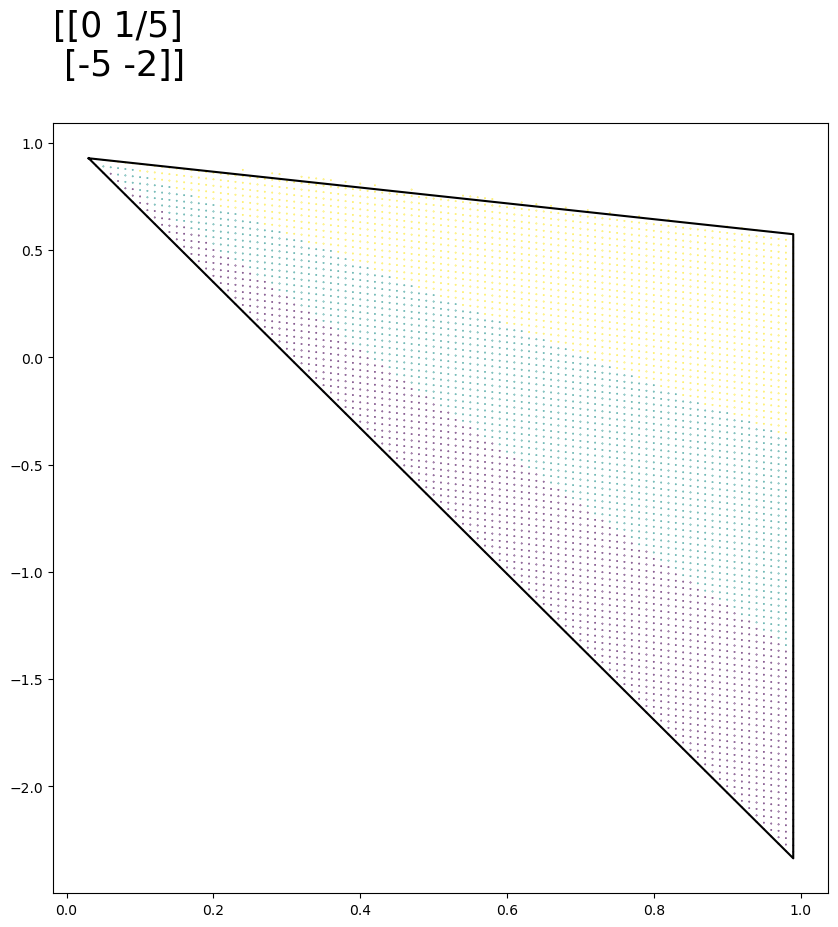

<Figure size 640x480 with 0 Axes>

section 1 done


In [8]:
t0 = time()
# list to check all output
all_output = []
dx = 0.01

# can change j to look at only one cusp
# for j in range(len(a[0])):
for j in range(1, 2):
    
    # list to collect output at each cusp
    cusp_output = []
    
    list_as = []
    list_cs = []
    list_es = []
    for a_, c_, e_ in zip(a, c, e):
        list_as.append(a_[j])
        list_cs.append(c_[j])
        list_es.append(e_[j])
    
    # Sort a, c, and e together based on the absolute value of the lower-right + lower-left entry of c
    sorted_pairs = sorted(zip(list_as, list_cs, list_es), key=lambda pair: abs(pair[1][1, 1]) + abs(pair[1][1,0]))
    
    # Unzip back into separate sorted lists
    sorted_a, sorted_c, sorted_e = zip(*sorted_pairs)
    
    # Convert tuples to lists
    sorted_a = list(sorted_a)
    sorted_c = list(sorted_c)
    sorted_e = list(sorted_e)

    for i in range(len(sorted_a)):
        # get dimensions of section
        vecs, x_vals, m0, m1, x0, y0, dx_y = setup(
            sorted_a[i], sorted_c[i], sorted_e[i], vecs0, dx)
        print("i = " + str(i), "j = " + str(j))

        # create a dataframe with winning vector at certain points in the section
        df = winners(vecs, x_vals, m0, m1, y0, dx, dx_y, dz = 1.5)
        # plot poincare section and save
        try:
            plot(df, vecs, sorted_c[i], j, n_squares, index, test=False)
        except Exception as error:
            print(error)
            continue

        # make section object that define winning vector and line equations for boundaries of subsections
        # sec_list = sec_setup(df, dx_y)
        # secs = sec_comp(sec_list, dx)
        sec_list2, vec_order, vec_dict = sec_setup2(df, dx_y)
        secs2 = sec_comp2(df, sec_list2, vec_order, vec_dict, dx, dx_y, m1, y0)
        
        print(f"section {j} done")
        break
t1 = time()

In [9]:
print(t1-t0)

366.07884454727173


In [21]:
len(valid_vecs[0]), len(slopes)

(1918, 1918)

In [12]:
df0 = pd.read_csv(os.path.join("results", f"{n_squares}_{index}", f"df_{1}.csv"))

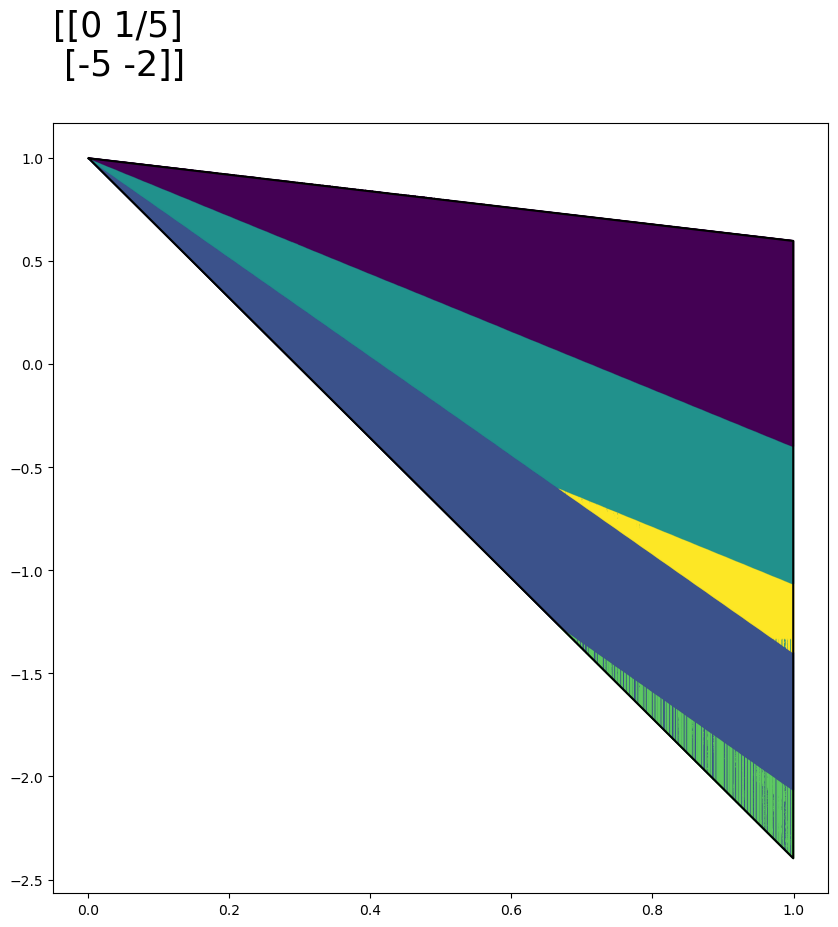

<Figure size 640x480 with 0 Axes>

In [14]:
plot(df0, vecs, sorted_c[i], j, n_squares, index, test=False)

In [20]:
df

,x,y,lab,vec,time
0,0.0010,0.998100000000000,2,"[[7/5], [1]]",1000.50025012506
1,0.0015,0.996400000000000,1,"[[12/5], [1]]",666.666666666667
2,0.0015,0.997900000000000,2,"[[7/5], [1]]",666.666666666667
3,0.0020,0.994700000000000,1,"[[12/5], [1]]",500.250125062531
4,0.0020,0.996200000000000,2,"[[7/5], [1]]",500.500500500501
...,...,...,...,...,...
1995535,0.9995,0.591200000000113,0,"[[2/5], [1]]",1.00958652888491
1995536,0.9995,0.592700000000113,0,"[[2/5], [1]]",1.00806070541557
1995537,0.9995,0.594200000000114,0,"[[2/5], [1]]",1.00653948704723
1995538,0.9995,0.595700000000114,0,"[[2/5], [1]]",1.00502285296328


In [19]:
df0["vec"].unique(), df["vec"].apply(str).unique()

(array(['[[7/5]\n [1]]', '[[12/5]\n [1]]', '[[2/5]\n [1]]',
        '[[21/5]\n [3]]', '[[36/5]\n [3]]'], dtype=object),
 array(['[[7/5]\n [1]]', '[[12/5]\n [1]]', '[[2/5]\n [1]]'], dtype=object))

In [ ]:
for i, results in enumerate(all_output):
    df = results[0]
    secs = results[1]
    secs2 = results[2]

    df0 = pd.read_csv(os.path.join("results", f"{n_squares} - {index}", f"df - {i}.csv"))
    
    with open(os.path.join("results", f"{n_squares} - {index}", f"secs - {i}.dill"), 'rb') as f:
        secs0 = dill.load(f)

    with open(os.path.join("results", f"{n_squares} - {index}", f"secs_integrals - {i}.dill"), 'rb') as f:
        secs2_0 = dill.load(f)

    print(f"cusp: {i}")
    if df[["x","y"]] == df0[["x","y"]]:
        print("setup passed")
    else:
        print("setup FAILED")
        break
        
    if df == df0:
        print("setup and winners passed")
    else:
        print("setup and winners FAILED")
        break
        
    if secs == secs0:
        print("secs passed")
    else:
        print("secs FAILED")
        
    if secs2 == secs2_0:
        print("secs2 passed")
    else:
        print("secs2 FAILED")

In [29]:
df0 = pd.read_csv(os.path.join("results", f"{n_squares} - {index}", f"df - {0}.csv"))

In [32]:
df0[["x", "y"]] = df

,x,y
0,0.0010,0.9965
1,0.0015,0.9935
2,0.0015,0.9960
3,0.0020,0.9905
4,0.0020,0.9930
...,...,...
1995608,0.9995,-0.0145
1995609,0.9995,-0.0120
1995610,0.9995,-0.0095
1995611,0.9995,-0.0070


In [34]:
df0 == df0

,x,y,lab,vec,time
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True
...,...,...,...,...,...
1995608,True,True,True,True,True
1995609,True,True,True,True,True
1995610,True,True,True,True,True
1995611,True,True,True,True,True


In [12]:
a = np.array([float("inf"), frac(int(2), int(2)), frac(int(3), int(4)), frac(int(3), int(5)), float("inf")])

In [13]:
np.argmin(a)

3

In [11]:
type(1)

<class 'sage.rings.integer.Integer'>